<a href="https://colab.research.google.com/github/dmburns1729/Class-Files/blob/main/Copy_of_Neural_Network_Kaggle_Exercise_DB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Core Assignment 1 - Kaggle Neural Network

- Name: David Burns
- Date: 12/12/2022

##Task

Now, put neural networks into action. You are tasked with building a neural network using data from this [kaggle competition](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data?select=sample_submission.csv). To complete the assignment, you will train and evaluate your model using only the train.csv. Remember, with Kaggle competitions, the test.csv does not include values for the target! The test.csv is only used for the competition, and you cannot evaluate your model using the test.csv without submitting your predictions to Kaggle.

Required Task:
1. Be sure to perform a train test split on the train.csv so you can evaluate your models.
2. Create and evaluate 3 iterations of a deep learning model to predict housing prices using the techniques you have learned to optimize your model's performance. Be sure to include some form of regularization with at least one model.
3. Select your best model!

Optional (but fun!)
- Use your best model to make predictions using the features in test.csv.
- Submit to the Kaggle competition to see how your did!
- Include a screenshot of your results from the Kaggle competition inserted in a markdown cell at the bottom of your notebook.

##Assignment

##Mount Drive | Import Libraries | Download Data

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import heatmap
from sklearn import set_config
set_config(display='diagram')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from imblearn.pipeline import make_pipeline

from sklearn.compose import make_column_selector, make_column_transformer

#Sci-kit Learn
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

#Keras
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
# load data
from google.colab import drive
drive.mount('/content/drive')
filename = '/content/train.csv'
df = pd.read_csv(filename, index_col = 'Id')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
76,180,RM,21.0,1596,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdWo,NaN,0,11,2009,WD,Normal,91000
226,160,RM,21.0,1680,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2009,COD,Abnorml,112000
228,160,RM,21.0,1869,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,106000
233,160,RM,21.0,1680,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,94500
236,160,RM,21.0,1680,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2008,WD,Normal,89500


## Preprocess the data

### Correlation to drop uncorrelated data and fill values

In [ ]:
# copy
df_copy = df.copy()

In [ ]:
# check duplicates
df_copy.duplicated().sum()

0

In [ ]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 76 to 1447
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBui

In [ ]:
df_copy['MSSubClass'] = df_copy['MSSubClass'].astype('object')

In [ ]:
#Create a features dataframe to encode categorical data for correlation
feat_df = df_copy.copy()
objList = feat_df.select_dtypes(include = "object").columns
feat_df[objList] = feat_df[objList].apply(LabelEncoder().fit_transform)

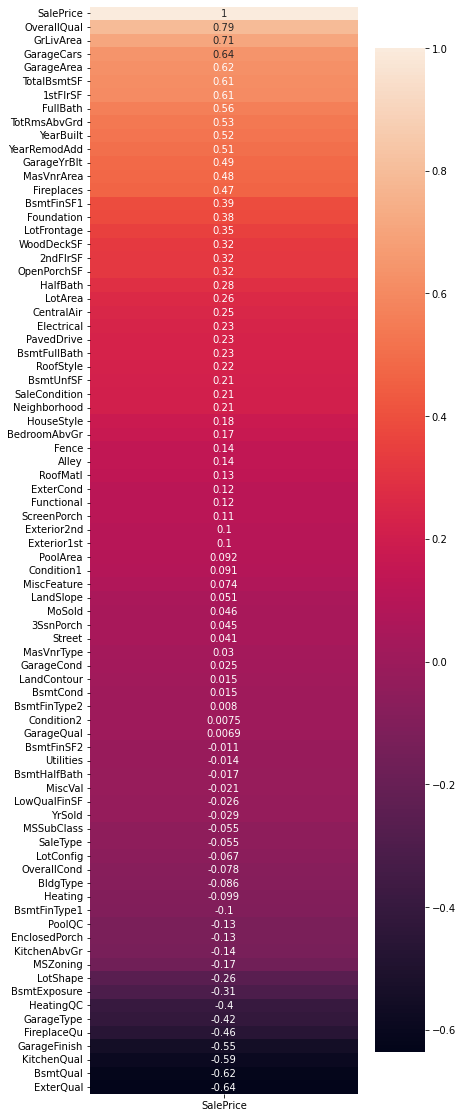

In [ ]:
#Sort the correlations of each column to SalePrice
corr = feat_df.corr()[['SalePrice']].sort_values(by = 'SalePrice', ascending = False)
plt.figure(figsize= (6,20))
sns.heatmap(corr, annot = True);

In [ ]:
df_group = df_copy.groupby("MSZoning")['SalePrice'].agg(['count', 'sum', 'mean', 'min', 'max'])
df_group

,count,sum,mean,min,max
MSZoning,,,,,
C (all),10,745280,74528.000000,34900,133900
FV,65,13910914,214014.061538,144152,370878
RH,16,2104934,131558.375000,76000,200000
RL,1151,219846749,191004.994787,39300,755000
RM,218,27537069,126316.830275,37900,475000


In [ ]:
#Select features with a greater or lesser correlation than 0.1 to SalePrice
df_copy = df_copy.copy()
df_copy.drop(columns = corr[(corr['SalePrice'] < 0.1) & (corr['SalePrice'] > -0.1)].index, inplace = True)

df_copy = df_copy[['MSZoning',
 'LotFrontage',
 'LotArea',
 'Alley',
 'LotShape',
 'Neighborhood',
 'HouseStyle',
 'OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'ScreenPorch',
 'PoolQC',
 'Fence',
 'SaleCondition']]

In [ ]:
#Create a features dataframe to encode categorical data for correlation
feat_df = df_copy.copy()
objList = feat_df.select_dtypes(include = "object").columns
feat_df[objList] = feat_df[objList].apply(LabelEncoder().fit_transform)

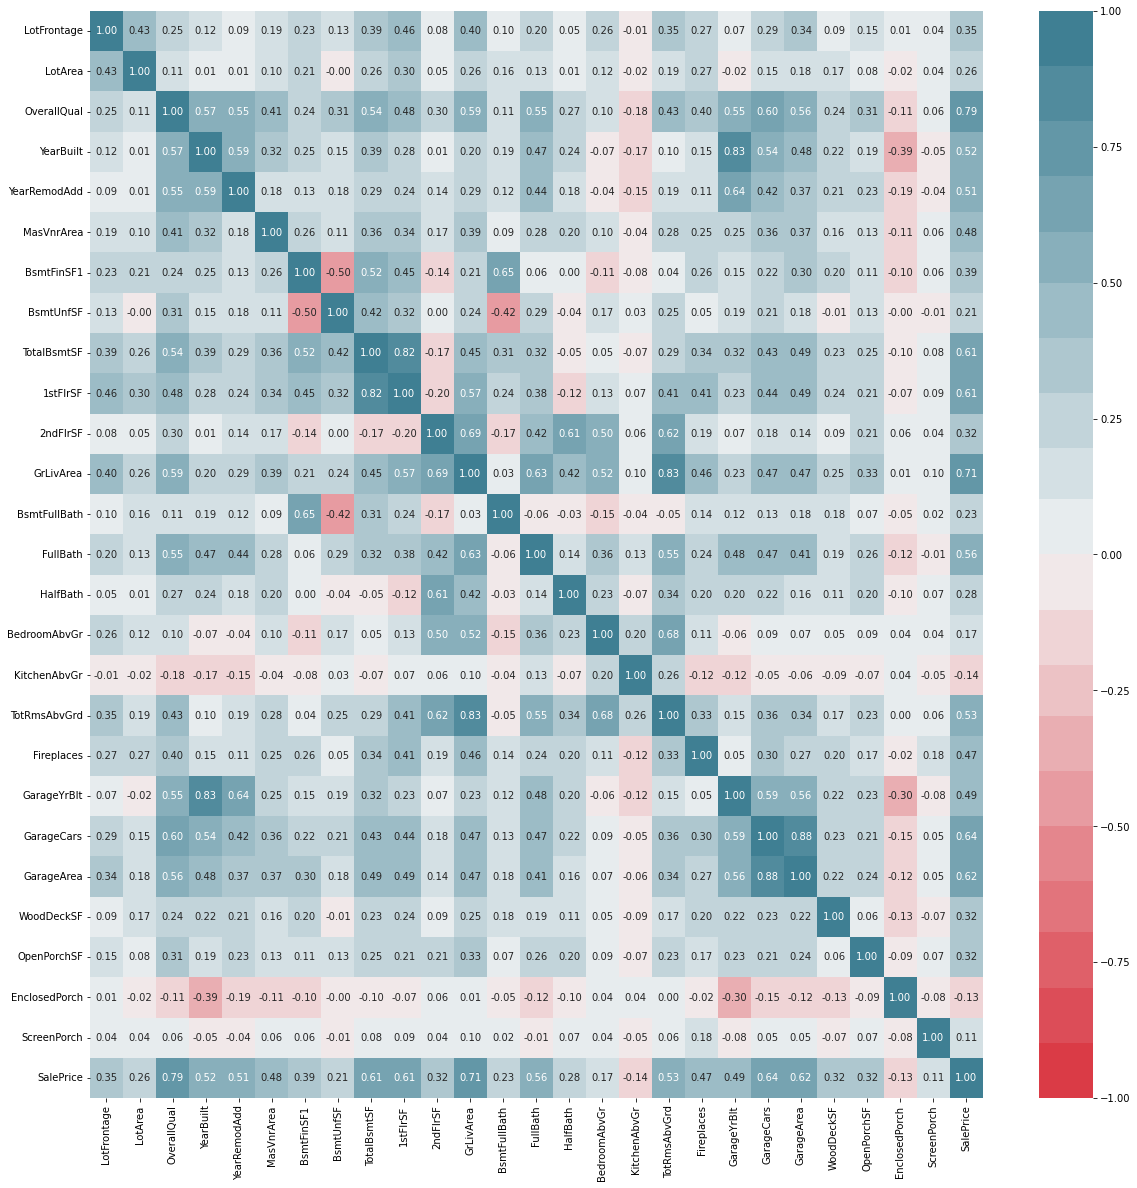

In [ ]:
corr = df_copy.corr()
plt.figure(figsize = (20,20));
sns.heatmap(corr, cmap=sns.diverging_palette(10, 220, n=20), annot = True, vmin=-1, vmax=1, center=0,fmt='.2f');

In [ ]:
# check missing values among objects
pd.set_option('display.max_rows', None)
df_copy.select_dtypes('object').isna().sum()

MSZoning            0
Alley            1369
LotShape            0
Neighborhood        0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtExposure       38
BsmtFinType1       37
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         0
Functional          0
FireplaceQu       690
GarageType         81
GarageFinish       81
PavedDrive          0
PoolQC           1453
Fence            1179
SaleCondition       0
dtype: int64

In [ ]:
# Loop through index values of the dataframe

def mszoning_fill(data_frame):

  for ind in data_frame.index:

    x = data_frame.loc[ind, 'MSZoning']

    if pd.isnull(x) == True:

      zoning_filter = df['MSSubClass'] == df.loc[ind, 'MSSubClass']
      df_zoning = df[zoning_filter]

      data_frame.loc[ind, 'MSZoning'] = df_zoning['MSZoning'].value_counts().index[0]

In [ ]:
mszoning_fill(df_copy)

In [ ]:
# Codes for the labels.  Many are ordinal!  http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

In [ ]:
# Fill missing data with none if appropriate

df_copy['Alley'].fillna('None', inplace=True)
df_copy['BsmtQual'].fillna('None', inplace=True)
df_copy['BsmtFinType1'].fillna('None', inplace=True)
df_copy['FireplaceQu'].fillna('None', inplace=True)
df_copy['GarageType'].fillna('None', inplace=True)
df_copy['GarageFinish'].fillna('None', inplace=True)
df_copy['PoolQC'].fillna('None', inplace=True)
df_copy['Fence'].fillna('None', inplace=True)

In [ ]:
lotshape_ordinal = {'Reg':0, 'IR1':1,'IR2':2,'IR3':3}
df_copy['LotShape'] = df_copy['LotShape'].replace(lotshape_ordinal)
df_copy['LotShape'].value_counts()


0    925
1    484
2     41
3     10
Name: LotShape, dtype: int64

In [ ]:
lotshape_ordinal = {'Reg':0, 'IR1':1,'IR2':2,'IR3':3}
df_copy['LotShape'] = df_copy['LotShape'].replace(lotshape_ordinal)
df_copy['LotShape'].value_counts()

0    925
1    484
2     41
3     10
Name: LotShape, dtype: int64

In [ ]:
ext_ordinal = {'None':0, 'NA':0,'No':1,'Mn':2,'Av':3, 'Gd':4}
df_copy['BsmtExposure'] = df_copy['BsmtExposure'].replace(ext_ordinal)

In [ ]:
df_copy['BsmtExposure'].value_counts()

1.0    953
3.0    221
4.0    134
2.0    114
Name: BsmtExposure, dtype: int64

In [ ]:
value_ordinal = {'None':0, 'Po':1,'Fa':2,'TA':3, 'Gd':4, 'Ex':5 }
df_copy['ExterQual'] = df_copy['ExterQual'].replace(value_ordinal)
df_copy['ExterCond'] = df_copy['ExterCond'].replace(value_ordinal)
df_copy['BsmtQual'] = df_copy['BsmtQual'].replace(value_ordinal)
df_copy['KitchenQual'] = df_copy['KitchenQual'].replace(value_ordinal)
df_copy['FireplaceQu'] = df_copy['FireplaceQu'].replace(value_ordinal)

In [ ]:
bsmtfin_ordinal = {'None':0, 'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6}
df_copy['BsmtFinType1'] = df_copy['BsmtFinType1'].replace(bsmtfin_ordinal)
df_copy['BsmtFinType1'].value_counts()

1    430
6    418
5    220
4    148
3    133
2     74
0     37
Name: BsmtFinType1, dtype: int64

In [ ]:
heating_ordinal = {'Po':0, 'Fa':1,'TA':2,'Gd':3,'Ex':4}
df_copy['HeatingQC'] = df_copy['HeatingQC'].replace(heating_ordinal)


In [ ]:
air_ordinal = {'N':0, 'Y':1}
df_copy['CentralAir'] = df_copy['CentralAir'].replace(air_ordinal)


In [ ]:
df_copy['Electrical'] = df_copy['Electrical'].fillna(df_copy['Electrical'].value_counts().index[0])
df_copy['Exterior1st'] = df_copy['Exterior1st'].fillna(df_copy['Exterior1st'].value_counts().index[0])
df_copy['Exterior2nd'] = df_copy['Exterior2nd'].fillna(df_copy['Exterior2nd'].value_counts().index[0])
df_copy['Functional'] = df_copy['Functional'].fillna(df_copy['Functional'].value_counts().index[0])





In [ ]:
df_copy.select_dtypes('object').isna().sum()

MSZoning         0
Alley            0
Neighborhood     0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
Foundation       0
Electrical       0
Functional       0
GarageType       0
GarageFinish     0
PavedDrive       0
PoolQC           0
Fence            0
SaleCondition    0
dtype: int64

In [ ]:
electrical_ordinal = {'Mix':0, 'FuseP':1, 'FuseF':2, 'FuseA':3, 'SBrkr':4}
df_copy['Electrical'] = df_copy['Electrical'].replace(electrical_ordinal)


In [ ]:
function_ordinal = {'Sal':0, 'Sev':1,'Maj2':2,'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7 }
df_copy['Functional'] = df_copy['Functional'].replace(function_ordinal)

In [ ]:
garage_ordinal = {'None':0, 'Unf':1,'RFn':2,'Fin':3}
df_copy['GarageFinish'] = df_copy['GarageFinish'].replace(garage_ordinal)

In [ ]:
drive_ordinal = {'N':0, 'P':1,'Y':2}
df_copy['PavedDrive'] = df_copy['PavedDrive'].replace(drive_ordinal)

In [ ]:
pool_ordinal = {'None':0, 'Fa':1,'TA':2,'Gd':3, 'Ex':4}
df_copy['PoolQC'] = df_copy['PoolQC'].replace(pool_ordinal)

In [ ]:
fence_ordinal = {'None':0, 'MnWw':1,'GdWo':2,'MnPrv':3, 'GdPrv':4}
df_copy['Fence'] = df_copy['Fence'].replace(fence_ordinal)

In [ ]:
# Loop through index values of the dataframe

def mszoning_fill(data_frame, data_frame_source):
  for ind in data_frame.index:
    x = data_frame.loc[ind, 'MSZoning']
    if pd.isnull(x) == True:
      zoning_filter = data_frame['MSSubClass'] == data_frame.loc[ind, 'MSSubClass']
      df_zoning = data_frame_source[zoning_filter]
      data_frame.loc[ind, 'MSZoning'] = df_zoning['MSZoning'].value_counts().index[0]

In [ ]:
mszoning_fill(df_copy, df)

In [ ]:
# check missing values among objects
pd.set_option('display.max_rows', None)
df_copy.select_dtypes('object').isna().sum()

MSZoning         0
Alley            0
Neighborhood     0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
Foundation       0
GarageType       0
SaleCondition    0
dtype: int64

All categorical missing values filled.  Now on to numeric.

In [ ]:
df_copy.select_dtypes('number').isna().sum()

LotFrontage      259
LotArea            0
LotShape           0
OverallQual        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
ExterQual          0
ExterCond          0
BsmtQual           0
BsmtExposure      38
BsmtFinType1       0
BsmtFinSF1         0
BsmtUnfSF          0
TotalBsmtSF        0
HeatingQC          0
CentralAir         0
Electrical         0
1stFlrSF           0
2ndFlrSF           0
GrLivArea          0
BsmtFullBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
KitchenQual        0
TotRmsAbvGrd       0
Functional         0
Fireplaces         0
FireplaceQu        0
GarageYrBlt       81
GarageFinish       0
GarageCars         0
GarageArea         0
PavedDrive         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
ScreenPorch        0
PoolQC             0
Fence              0
SalePrice          0
dtype: int64

In [ ]:
df_copy['BsmtExposure'].fillna(0, inplace=True)
df_copy['MasVnrArea'].fillna(0, inplace=True)

In [ ]:
# GarageArea and GarageCars are highly correlated

# df_copy.drop(columns = {'GarageArea'}, inplace = True)



In [ ]:
#Create a features dataframe to encode categorical data for correlation
feat_df = df.copy()
objList = feat_df.select_dtypes(include = "object").columns
feat_df[objList] = feat_df[objList].apply(LabelEncoder().fit_transform)

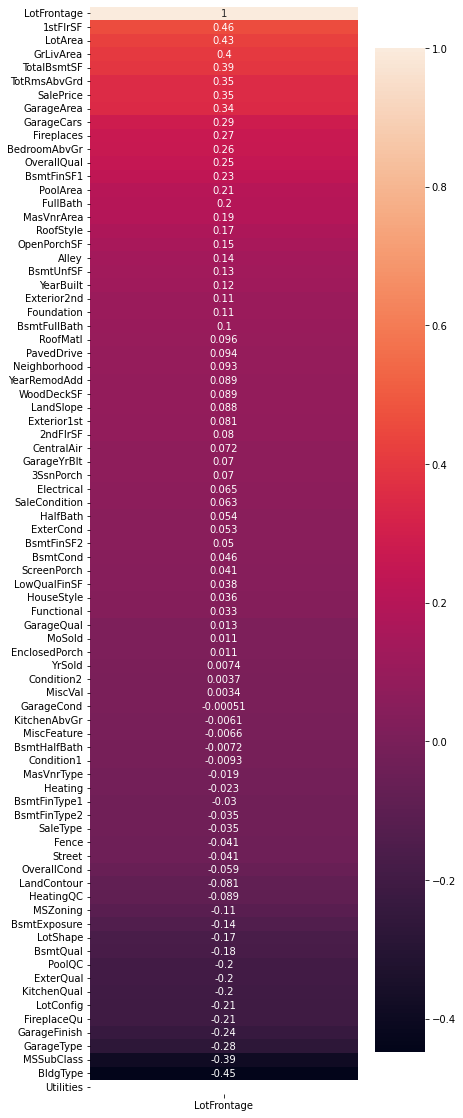

In [ ]:
#Sort the correlations of each column to SalePrice
corr = feat_df.corr()[['LotFrontage']].sort_values(by = 'LotFrontage', ascending = False)
plt.figure(figsize= (6,20))
sns.heatmap(corr, annot = True);

In [ ]:
df_bldg = df.groupby('BldgType')['LotFrontage'].agg(['count', 'sum', 'mean', 'min', 'max'])
df_bldg

,count,sum,mean,min,max
BldgType,,,,,
1Fam,994,74056.0,74.503018,30.0,313.0
2fmCon,28,1860.0,66.428571,33.0,107.0
Duplex,47,3365.0,71.595745,35.0,110.0
Twnhs,40,987.0,24.675000,21.0,36.0
TwnhsE,92,3862.0,41.978261,21.0,75.0


In [ ]:
# Loop through index values of the dataframe

def fill_LotFrontage(data_frame, fill_data):

  for ind in data_frame.index:

    x = data_frame.loc[ind, 'LotFrontage']

    if np.isnan(x) == True:

      # Impute LotFrontage based on average of sqauare root of Lot Area and 1stFlrSF estimators

      # Create a filter to select the BldgType corresponding to the index
      type_filter = fill_data['BldgType'] == fill_data.loc[ind, 'BldgType']
      df_type = data_frame[type_filter]

      ratio_area_est = df_type['LotFrontage'] / (df_type['LotArea']) ** (1/2)
      area_est = ratio_area_est.mean() * df_type.loc[ind, 'LotArea'] ** (1/2)
#      print(area_est)

      ratio_first_est = df_type['LotFrontage'] / (df_type['1stFlrSF']) ** (1/2)
      first_est = ratio_first_est.mean() * df_type.loc[ind, '1stFlrSF'] ** (1/2)
#      print(first_est)

      frontage_est = round((area_est + first_est) / 2,0)
      frontage_est = int(frontage_est)
#      print(frontage_est)

      data_frame.loc[ind, 'LotFrontage'] = int(frontage_est)

      data_frame.loc[ind, 'LotFrontage'] = int(data_frame.loc[ind, 'LotFrontage'])

#      print(data_frame.loc[ind, 'LotFrontage'])
#      print("\n")

In [ ]:
fill_LotFrontage(df_copy,df)

In [ ]:
df_copy['MasVnrArea'].fillna(0, inplace=True)

In [ ]:
# Loop through index values of the dataframe
# Will need to fill with this formula AFTER test, train split

def garage_year_fill(data_frame):

  for ind in data_frame.index:

    x = data_frame.loc[ind, 'GarageYrBlt']

    if np.isnan(x) == True:

      data_frame.loc[ind, 'GarageYrBlt'] = data_frame.loc[ind, 'YearBuilt']



In [ ]:
garage_year_fill(df_copy)

In [ ]:
df_copy.select_dtypes('number').isna().sum()

LotFrontage      0
LotArea          0
LotShape         0
OverallQual      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
ExterQual        0
ExterCond        0
BsmtQual         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtUnfSF        0
TotalBsmtSF      0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
GrLivArea        0
BsmtFullBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
ScreenPorch      0
PoolQC           0
Fence            0
SalePrice        0
dtype: int64

## Correlation for Feature Selection

In [ ]:
for col in df_copy.select_dtypes('object'):
    print(f'{col}:\n')
    print(df_copy[col].value_counts())
    print("\n\n")


MSZoning:

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64



Alley:

None    1369
Grvl      50
Pave      41
Name: Alley, dtype: int64



Neighborhood:

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64



HouseStyle:

1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64



RoofStyle:

Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64



RoofMatl:

CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5


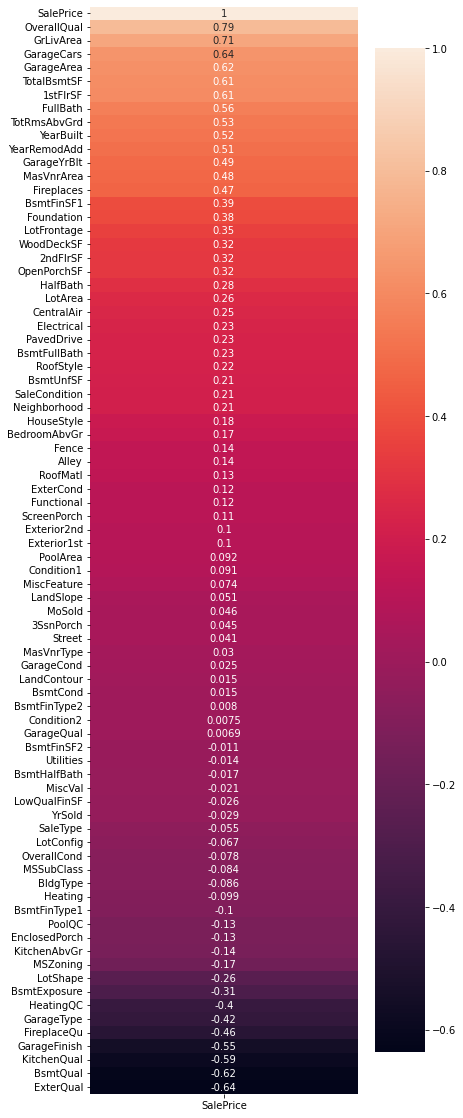

In [ ]:
#Sort the correlations of each column to SalePrice
corr = feat_df.corr()[['SalePrice']].sort_values(by = 'SalePrice', ascending = False)
plt.figure(figsize= (6,20))
sns.heatmap(corr, annot = True);

In [ ]:
df_copy['BsmtQual'].value_counts()

3    649
4    618
5    121
0     37
2     35
Name: BsmtQual, dtype: int64

In [ ]:
#Select features with a greater or lesser correlation than 0.25 to SalePrice
#train_df = df.copy()
#train_df.drop(columns = corr[(corr['SalePrice'] < 0.1) & (corr['SalePrice'] > -0.1)].index, inplace = True)

In [ ]:
##Sort the correlations of each column to SalePrice
#corr = feat_df.corr()[['LotFrontage']].sort_values(by = 'LotFrontage', ascending = False)
#plt.figure(figsize= (8,20))
#sns.heatmap(corr, annot = True);

In [ ]:
##Sort the correlations of each column to SalePrice
#corr = feat_df.corr()[['BldgType']].sort_values(by = 'BldgType', ascending = False)
#plt.figure(figsize= (8,20))
#sns.heatmap(corr, annot = True);

In [ ]:
#df_copy.dropna(inplace=True)
#df_copy = df_copy.drop(columns={'Longitude', 'Latitude'})

In [ ]:
# checking any inconsistent values
df_copy.describe(include= 'all')

,MSZoning,LotFrontage,LotArea,Alley,LotShape,Neighborhood,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,...,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolQC,Fence,SaleCondition,SalePrice
count,1460,1460.000000,1460.000000,1460,1460.000000,1460,1460,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460.000000
unique,5,NaN,NaN,3,NaN,25,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN
top,RL,NaN,NaN,None,NaN,NAmes,1Story,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN
freq,1151,NaN,NaN,1369,NaN,225,726,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1198,NaN
mean,NaN,71.015753,10516.828082,NaN,0.408219,NaN,NaN,6.099315,1971.267808,1984.865753,...,472.980137,1.856164,94.244521,46.660274,21.954110,15.060959,0.013014,0.565753,NaN,180921.195890
std,NaN,23.748001,9981.264932,NaN,0.582296,NaN,NaN,1.382997,30.202904,20.645407,...,213.804841,0.496592,125.338794,66.256028,61.119149,55.757415,0.204059,1.204483,NaN,79442.502883
min,NaN,21.000000,1300.000000,NaN,0.000000,NaN,NaN,1.000000,1872.000000,1950.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,34900.000000
25%,NaN,60.000000,7553.500000,NaN,0.000000,NaN,NaN,5.000000,1954.000000,1967.000000,...,334.500000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,129975.000000
50%,NaN,70.000000,9478.500000,NaN,0.000000,NaN,NaN,6.000000,1973.000000,1994.000000,...,480.000000,2.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,NaN,163000.000000
75%,NaN,81.000000,11601.500000,NaN,1.000000,NaN,NaN,7.000000,2000.000000,2004.000000,...,576.000000,2.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,NaN,214000.000000


In [ ]:
# This for loop will check valuecounts in object columns
# This is causing problems with OHE of the test data

#for col in df_copy.select_dtypes('object'):
#    print(f'{col}:\n')
#    print(df_copy[col].value_counts())
#    print("\n\n")

In [ ]:
#!pip install dython

In [ ]:
#from dython.nominal import associations


In [ ]:
# Explore correlations
#associations(df_copy, figsize=(80,80),fmt='.2f', vmin=-1, vmax=1,cmap=sns.diverging_palette(10, 220, n=20));


In [ ]:
# I will drop some of the large value categorical columns with low correlation to sale price that will junk up the columns after OHE

#df_copy = df_copy.drop(columns={'MSSubClass','Street', 'LandSlope', 'OverallCond', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', '3SsnPorch','MiscVal' })


In [ ]:
# This for loop will check valuecounts in object columns
# This is causing problems with OHE of the test data

for col in df_copy.select_dtypes('object'):
    print(f'{col}:\n')
    print(df_copy[col].value_counts().head(10))
    print(df_copy[col].value_counts().tail(10))

    print("\n\n")

MSZoning:

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64



Alley:

None    1369
Grvl      50
Pave      41
Name: Alley, dtype: int64
None    1369
Grvl      50
Pave      41
Name: Alley, dtype: int64



Neighborhood:

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
Name: Neighborhood, dtype: int64
IDOTRR     37
ClearCr    28
SWISU      25
StoneBr    25
Blmngtn    17
MeadowV    17
BrDale     16
Veenker    11
NPkVill     9
Blueste     2
Name: Neighborhood, dtype: int64



HouseStyle:

1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64
1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11

In [ ]:
# # explore numeric distributions via boxplots to see outliers
#%%time
#for col in df_copy.select_dtypes('int64'):
#  print('\n', col, '\n')
#  df_copy[col].plot(kind='box')
#  plt.show()

In [ ]:
df_copy['BathroomTotCount'] = df_copy['BsmtFullBath'] + df_copy['FullBath'] + df_copy['HalfBath'] + df['BsmtHalfBath']

df_copy['BathroomBedroomRatio'] = df_copy['BathroomTotCount'] / df_copy['BedroomAbvGr']
df_copy['BathroomBedroomRatio'].value_counts()

1.000000    504
0.666667    312
0.500000    180
0.333333    108
1.333333     96
1.500000     84
0.750000     79
2.000000     40
3.000000     17
0.400000      9
inf           6
0.250000      6
0.800000      5
1.250000      5
0.600000      4
0.200000      2
1.666667      2
4.000000      1
Name: BathroomBedroomRatio, dtype: int64

In [ ]:
print("Number of rows in the data:", df_copy.shape[0])
print("Number of columns in the data:", df_copy.shape[1])

Number of rows in the data: 1460
Number of columns in the data: 56


In [ ]:
# Replace infinite updated data with nan
df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop rows with NaN

df_copy['BathroomBedroomRatio'].fillna(df_copy['BathroomBedroomRatio'].max(), inplace=True)


#df_copy.dropna(inplace=True)

In [ ]:
print("Number of rows in the data:", df_copy.shape[0])
print("Number of columns in the data:", df_copy.shape[1])

Number of rows in the data: 1460
Number of columns in the data: 56


In [ ]:
print("New Shape: ", df_copy.shape)


New Shape:  (1460, 56)


###Remove Outliers

hange cell to code	Y	Ctrl + M + Y
Change cell to markdown	M	Ctrl + M + M

# REMOVING OUTLIERS
# Identifying Interquantile Range
# IQR

for col in df_copy.select_dtypes('int64'):
  q_low = df_copy[col].quantile(0.1)
  q_high = df_copy[col].quantile(0.9)
  IQR = Q_high - Q_low
  
  # Bound
  lower_bound = q_low - 1.5 * IQR
  upper_bound = q_high + 1.5 * IQR

  # Removing the Outliers
  df_copy = df_copy[~((df_copy[col] < lower_bound) | (df_copy[col] > upper_bound))]

  sns.boxplot(x=col, data=df_copy);
  plt.figure(facecolor='#eaeaf2');


  # New Summary Statistics
print("New Shape: ", df_copy.shape)
display(round(df_copy.describe()))


In [ ]:
print("Number of rows in the data:", df_copy.shape[0])
print("Number of columns in the data:", df_copy.shape[1])

Number of rows in the data: 1460
Number of columns in the data: 56


In [ ]:
df_copy.head()

,MSZoning,LotFrontage,LotArea,Alley,LotShape,Neighborhood,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolQC,Fence,SaleCondition,SalePrice,BathroomTotCount,BathroomBedroomRatio
Id,,,,,,,,,,,,,,,,,,,,,
76,RM,21.0,1596,None,0,MeadowV,SLvl,4,1973,1973,...,120,101,0,0,0,2,Normal,91000,2,1.0
226,RM,21.0,1680,None,0,BrDale,2Story,5,1971,1971,...,0,0,0,0,0,0,Abnorml,112000,3,1.0
228,RM,21.0,1869,None,0,BrDale,2Story,6,1970,1970,...,0,0,0,0,0,0,Normal,106000,2,1.0
233,RM,21.0,1680,None,0,BrDale,2Story,6,1972,1972,...,0,0,0,0,0,0,Normal,94500,2,1.0
236,RM,21.0,1680,None,0,BrDale,2Story,6,1971,1971,...,0,0,0,0,0,0,Normal,89500,2,1.0


In [ ]:
# Eliminate outliers

df_copy = df_copy.loc[df_copy['LotArea'] <= 25000,:]
#df_copy = df_copy.loc[df_copy['SalePrice'] <= 500000,:]
df_copy = df_copy.loc[df_copy['BsmtFinSF1'] <= 2000,:]
df_copy = df_copy.loc[df_copy['MasVnrArea'] <= 1200,:]
df_copy = df_copy.loc[df_copy['TotalBsmtSF'] <= 3000,:]
df_copy = df_copy.loc[df_copy['1stFlrSF'] <= 2500,:]
df_copy = df_copy.loc[df_copy['GrLivArea'] <= 4000,:]

#Don't eliminate outliers in LotFrontage until after imputing values
df_copy = df_copy.loc[df_copy['LotFrontage'] <= 140,:]



print("Number of rows in the data:", df_copy.shape[0])
print("Number of columns in the data:", df_copy.shape[1])


Number of rows in the data: 1412
Number of columns in the data: 56


In [ ]:
#%%time
#for col in df_copy.select_dtypes('int64'):
#  print('\n', col, '\n')
#  sns.set(style="darkgrid")
#  sns.histplot(data=df_copy, x=col, palette="ch:.10");
#  plt.show()

There are a lot out outliers here!  I will run everything with the outliers then decide if I need to do something about them.  It looks like they are not accidential so I may try to use some data engineering.

There are also a lot of rows that have a lot of zeros. In fact, I think that many of these should be binary not features like they are listed. That is, if there is a porch that should be yes/no.  Square footage doesn't seem to add much value.

## Visualization

In [ ]:
area = df_copy['LotArea'] ** (1/2)
df_viz = df_copy.copy()
df_viz['Root Area'] = area

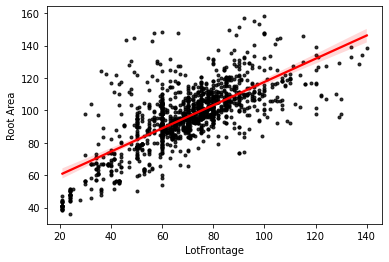

In [ ]:
 sns.regplot(data=df_viz,
                x='LotFrontage',
                y='Root Area',
                x_ci='ci',
                ci=99,
                marker='.',
                scatter_kws={"color": "black"},
                line_kws={"color": "red"},
                ax=None);


 LotFrontage 



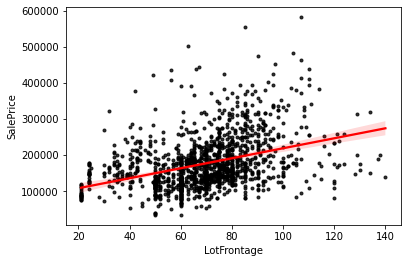


 LotArea 



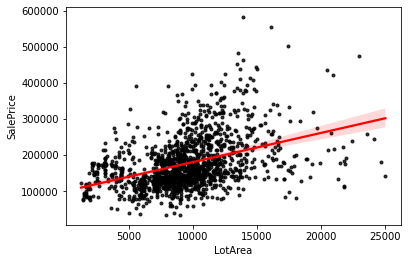


 LotShape 



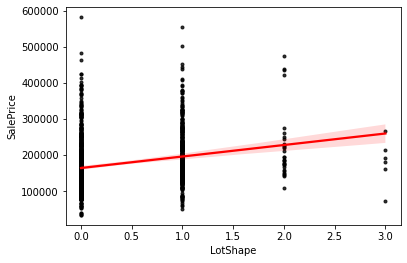


 OverallQual 



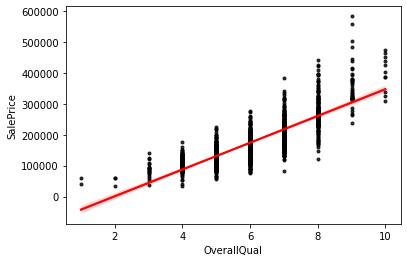


 YearBuilt 



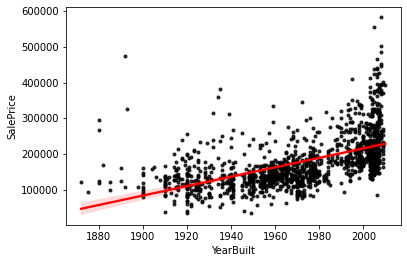


 YearRemodAdd 



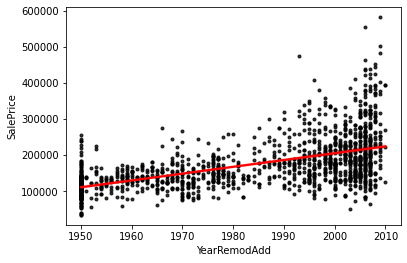


 MasVnrArea 



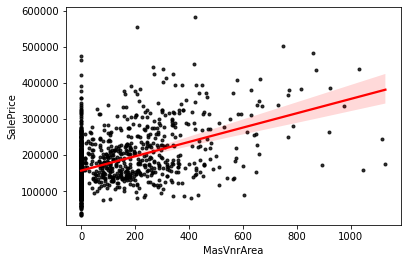


 ExterQual 



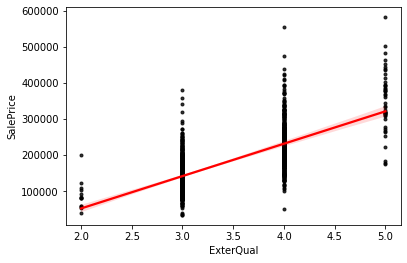


 ExterCond 



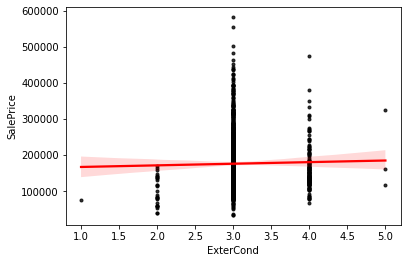


 BsmtQual 



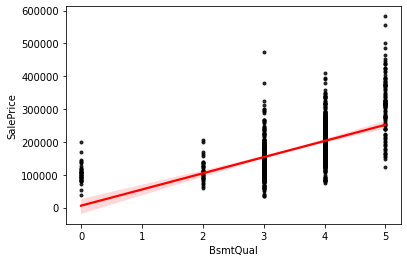


 BsmtExposure 



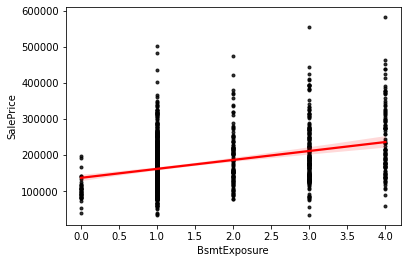


 BsmtFinType1 



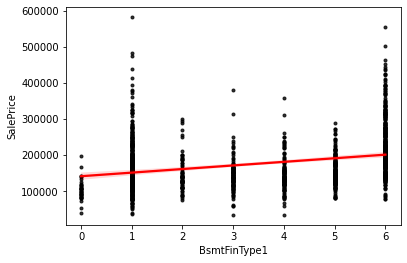


 BsmtFinSF1 



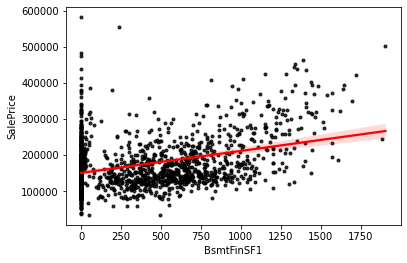


 BsmtUnfSF 



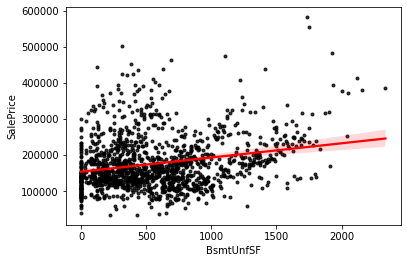


 TotalBsmtSF 



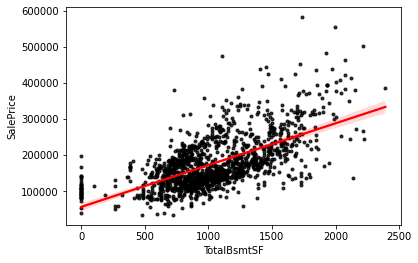


 HeatingQC 



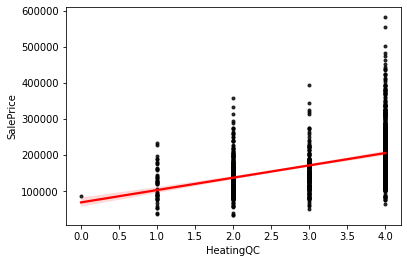


 CentralAir 



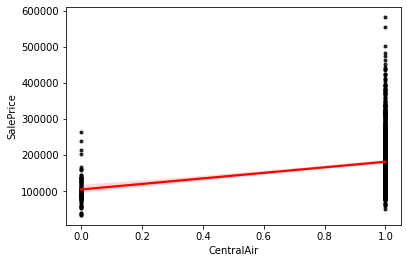


 Electrical 



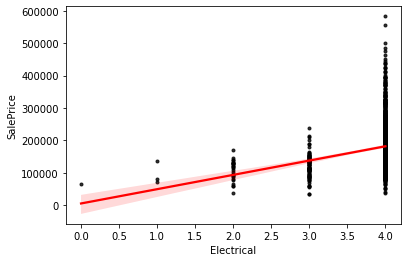


 1stFlrSF 



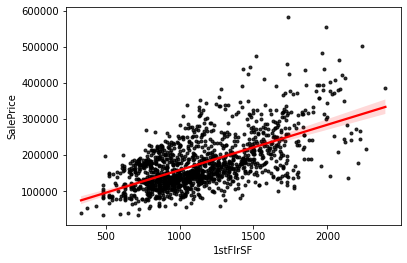


 2ndFlrSF 



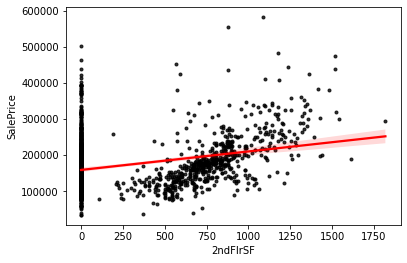


 GrLivArea 



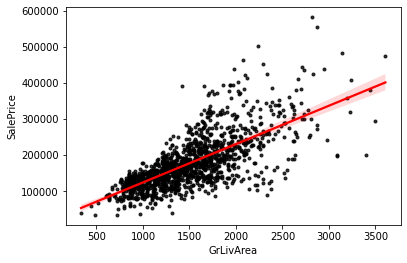


 BsmtFullBath 



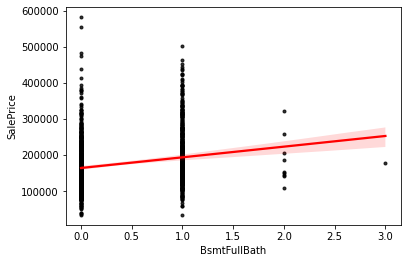


 FullBath 



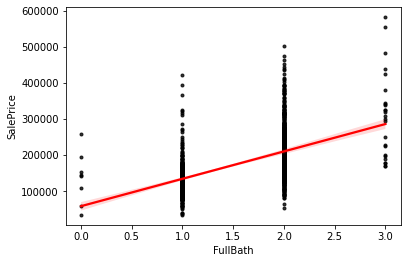


 HalfBath 



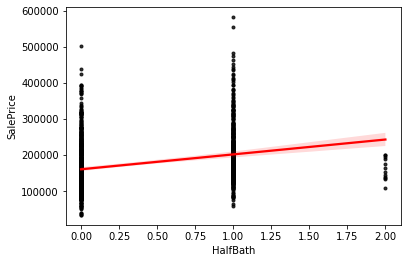


 BedroomAbvGr 



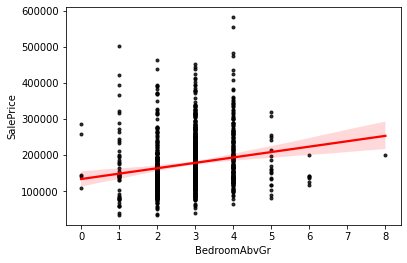


 KitchenAbvGr 



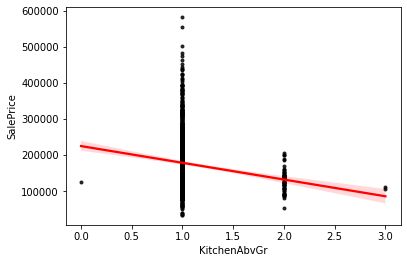


 KitchenQual 



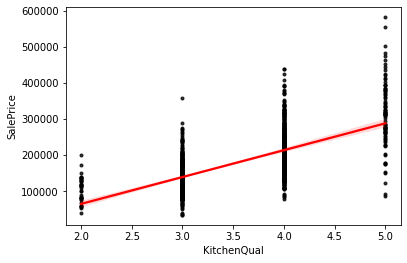


 TotRmsAbvGrd 



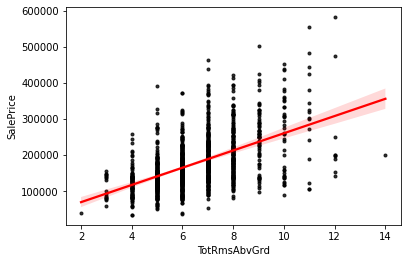


 Functional 



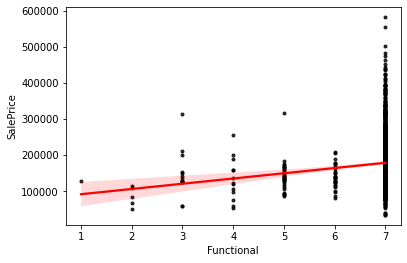


 Fireplaces 



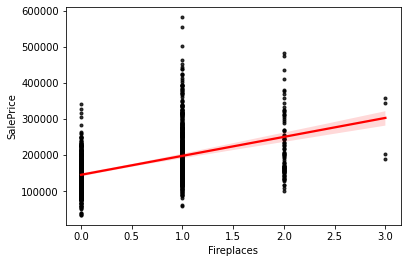


 FireplaceQu 



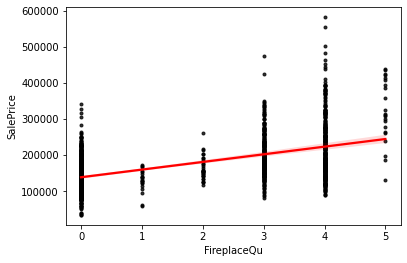


 GarageYrBlt 



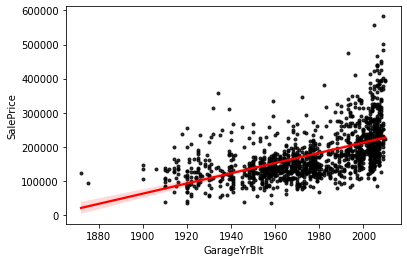


 GarageFinish 



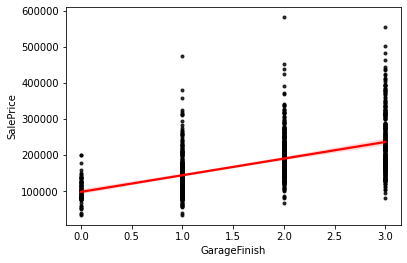


 GarageCars 



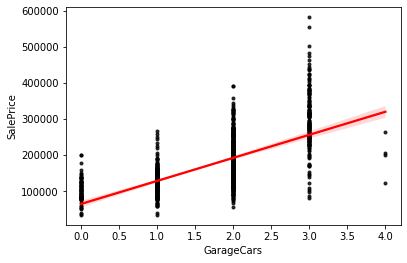


 GarageArea 



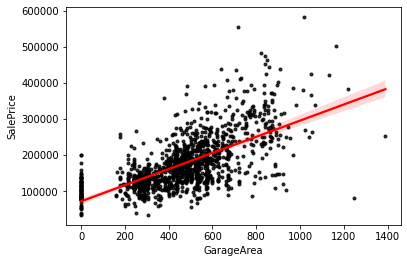


 PavedDrive 



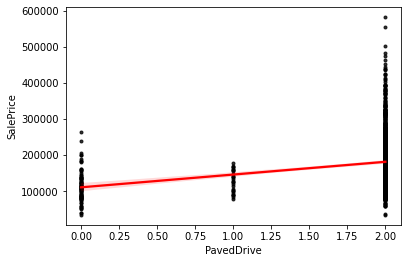


 WoodDeckSF 



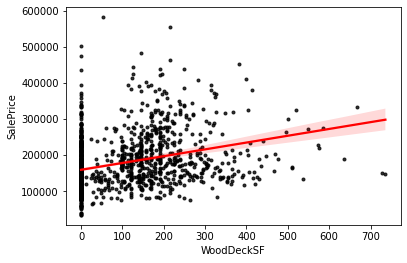


 OpenPorchSF 



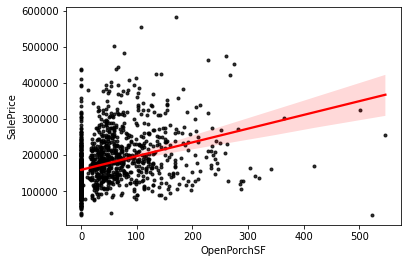


 EnclosedPorch 



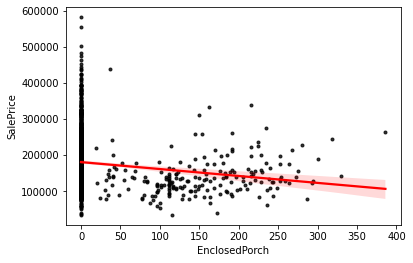


 ScreenPorch 



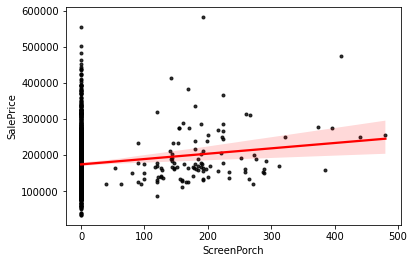


 PoolQC 



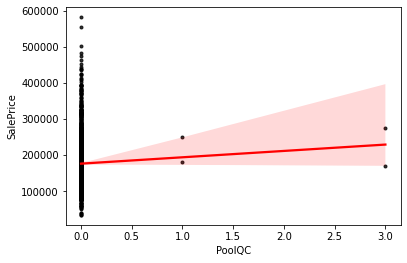


 Fence 



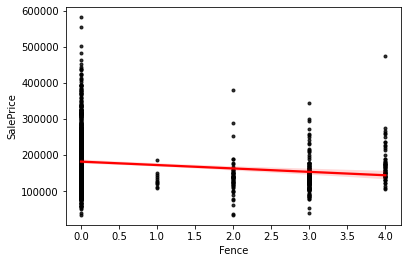


 SalePrice 



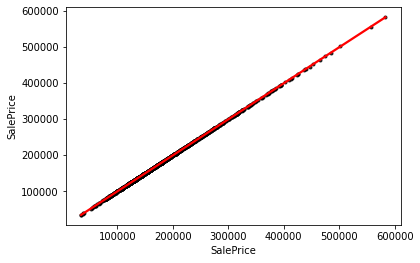


 BathroomTotCount 



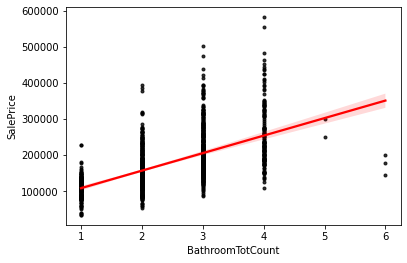


 BathroomBedroomRatio 



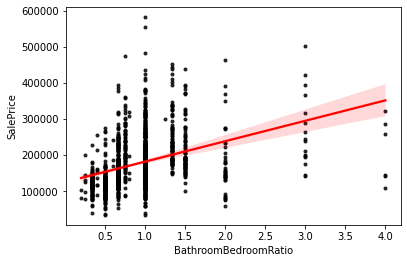

CPU times: user 19.5 s, sys: 4.1 s, total: 23.6 s
Wall time: 20.5 s


In [ ]:
%%time
for col in df_copy.select_dtypes('number'):
  print('\n', col, '\n')
  sns.regplot(data=df_copy,
                x=col,
                y='SalePrice',
                x_ci='ci',
                ci=99,
                marker='.',
                scatter_kws={"color": "black"},
                line_kws={"color": "red"},
                ax=None);
  plt.show()


In [ ]:
#Create a features dataframe to encode categorical data for correlation
feat_df = df_copy.copy()
objList = feat_df.select_dtypes(include = "object").columns
feat_df[objList] = feat_df[objList].apply(LabelEncoder().fit_transform)


 MSZoning 



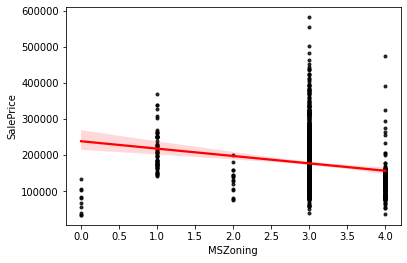


 Alley 



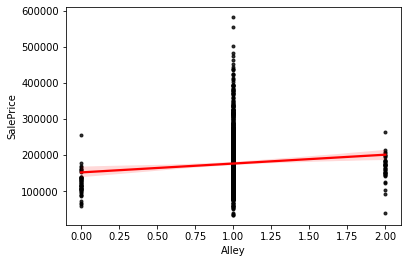


 Neighborhood 



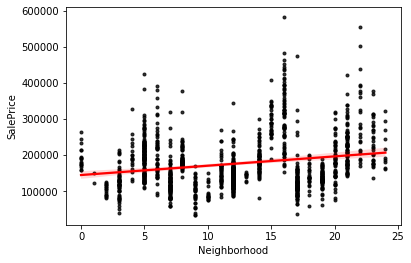


 HouseStyle 



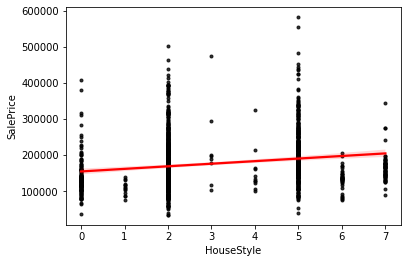


 RoofStyle 



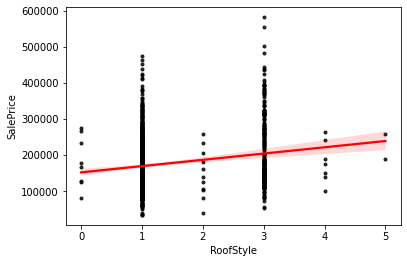


 RoofMatl 



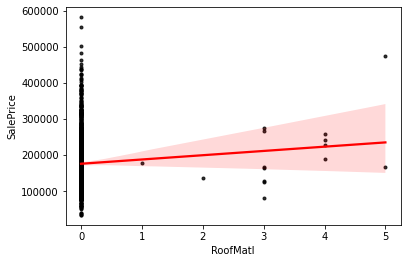


 Exterior1st 



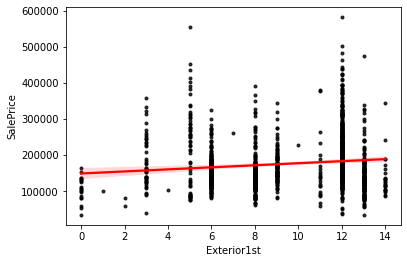


 Exterior2nd 



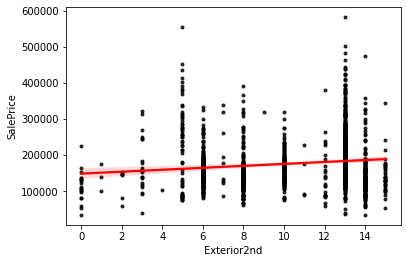


 Foundation 



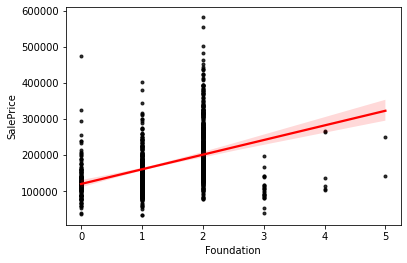


 GarageType 



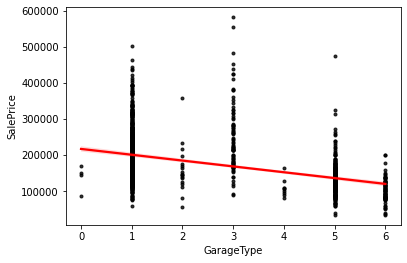


 SaleCondition 



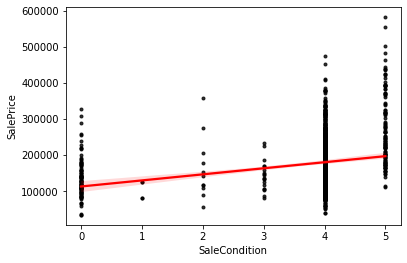

CPU times: user 4.59 s, sys: 1.01 s, total: 5.6 s
Wall time: 4.78 s


In [ ]:
%%time
for col in df_copy.select_dtypes('object'):
  print('\n', col, '\n')
  sns.regplot(data=feat_df,
                x=col,
                y='SalePrice',
                x_ci='ci',
                ci=99,
                marker='.',
                scatter_kws={"color": "black"},
                line_kws={"color": "red"},
                ax=None);
  plt.show()

In [ ]:
# Some of these correlations don't make sense.  No reason that
#'OverallCond' 'BsmtFinSF2' 'BsmtHalfBath' 'EnclosedPorch' 'MiscVal' should be negatively correlated

#df_copy = df_copy.drop(columns={'OverallCond', 'BsmtFinSF2', 'BsmtHalfBath', 'EnclosedPorch', 'MiscVal'})



In [ ]:
df_copy.to_csv('Kaggle_test_data.csv')

# Machine Learning

In [ ]:
df_ml = df_copy.copy()

In [ ]:
df_ml.shape

(1412, 56)

# Defining X and y

In [ ]:
df_ml

,MSZoning,LotFrontage,LotArea,Alley,LotShape,Neighborhood,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolQC,Fence,SaleCondition,SalePrice,BathroomTotCount,BathroomBedroomRatio
Id,,,,,,,,,,,,,,,,,,,,,
76,RM,21.0,1596,None,0,MeadowV,SLvl,4,1973,1973,...,120,101,0,0,0,2,Normal,91000,2,1.000000
226,RM,21.0,1680,None,0,BrDale,2Story,5,1971,1971,...,0,0,0,0,0,0,Abnorml,112000,3,1.000000
228,RM,21.0,1869,None,0,BrDale,2Story,6,1970,1970,...,0,0,0,0,0,0,Normal,106000,2,1.000000
233,RM,21.0,1680,None,0,BrDale,2Story,6,1972,1972,...,0,0,0,0,0,0,Normal,94500,2,1.000000
236,RM,21.0,1680,None,0,BrDale,2Story,6,1971,1971,...,0,0,0,0,0,0,Normal,89500,2,1.000000
364,RM,21.0,1680,None,0,BrDale,2Story,6,1972,2007,...,250,0,0,0,0,0,Normal,118000,2,1.000000
431,RM,21.0,1680,None,0,BrDale,2Story,6,1971,1971,...,0,0,0,0,0,0,Abnorml,85400,2,1.000000
435,RM,21.0,1890,None,0,MeadowV,SFoyer,4,1972,1972,...,88,0,0,0,0,0,Normal,81000,2,2.000000
490,RM,21.0,1526,None,0,MeadowV,SFoyer,4,1970,2002,...,0,0,0,0,0,0,Normal,86000,2,2.000000


In [ ]:
# features
X = df_ml.drop(columns='SalePrice')

# target
y = df_ml['SalePrice']

In [ ]:
X.shape

(1412, 55)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 32,test_size=0.1)

In [ ]:
#instantiate the StandardScaler, OneHotEncoder, and Imputers
scaler = MinMaxScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
mean_imputer = SimpleImputer(strategy='mean')
freq_imputer = SimpleImputer(strategy='most_frequent')

# Setup the pipelines for the numeric and categorical data
num_pipeline = make_pipeline(mean_imputer, scaler)
nom_pipeline = make_pipeline(freq_imputer, ohe)

# make selector columns:
num_selector = make_column_selector(dtype_include = 'number')
cat_selector = make_column_selector(dtype_include = 'object')

# Setup the tuples to pair the processors with the make column selectors
numeric_tuple = (num_pipeline, num_selector)
nominal_tuple = (nom_pipeline, cat_selector)

# make pipeline with Preprocessing and PCA
#pca = PCA(n_components = .9999)
preprocessor = make_column_transformer(numeric_tuple, nominal_tuple, remainder='drop')
#pca_processing = make_pipeline(preprocessor, pca)
#pca_processing

# Fit the column transformer on the X_train
#pca_processing.fit(X_train)

preprocessor.fit(X_train)

# Transform the X_train and the X_test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# check
X_train_processed.dtype

dtype('float64')

In [ ]:
X_train_processed.shape

(1270, 146)

In [ ]:
np.isnan(X_train_processed).sum()

0

In [ ]:
np.isnan(X_test_processed).sum()

0

In [ ]:
X_test_processed.dtype

dtype('float64')

In [ ]:
input_dim = X_train_processed.shape[1]
input_dim

146

In [ ]:
def plot_history(history):
  """Takes a keras model learning history and plots each metric"""

  metrics = history.history.keys()

  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

In [ ]:
## define the evaluate_regression function here.

def evaluate_regression(model, X_test, y_test, label="Test Data"):
  y_pred = model.predict(X_test)


   ## Print regression report for the test data
  print('---'*20)
  print(f"REGRESSION REPORT FOR: {label}")
  print('---'*20)
  # print the classiffication report from the test data

  print(f'final RMSE: {round(np.sqrt(mean_squared_error(y_test, y_pred)),-1)}')
  print(f'final MAE: {round(mean_absolute_error(y_test, y_pred),-1)}')
  print(f'final R2: {round(r2_score(y_test, y_pred),4)}')

  plt.show()

In [ ]:
# create model
model = Sequential()
model.add(Dense(200, input_dim = input_dim, activation = 'relu'))
model.add(Dense(150, activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mse', optimizer = 'adam', metrics=[metrics.MeanAbsoluteError(),metrics.RootMeanSquaredError()])

In [ ]:
# fit your model
%%time
history = model.fit(X_train_processed, y_train,
                    validation_data=(X_test_processed, y_test),
                    epochs=200,
                    verbose=0)

CPU times: user 37.6 s, sys: 1.5 s, total: 39.1 s
Wall time: 42.9 s


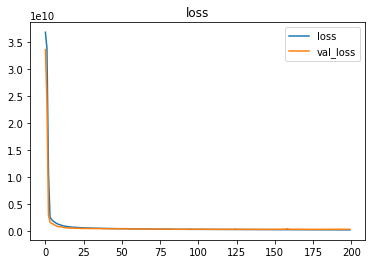

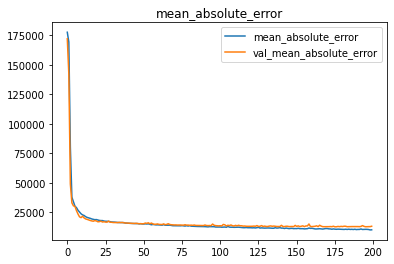

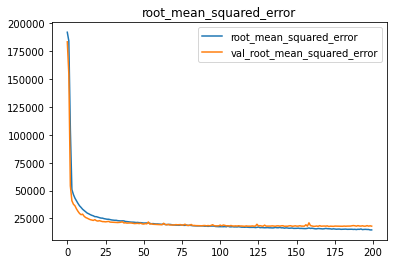

In [ ]:
# plot learning

plot_history(history)

In [ ]:
evaluate_regression(model, X_test_processed, y_test, label="Test Data");

5/5 [==============================] - 0s 3ms/step
------------------------------------------------------------
REGRESSION REPORT FOR: Test Data
------------------------------------------------------------
final RMSE: 18050.0
final MAE: 13080.0
final R2: 0.9202


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 5)

#del model2

# create model
model2 = Sequential()
model2.add(Dense(200, activation = 'relu'))
model2.add(Dense(150, activation = 'relu'))
model2.add(Dense(100, activation = 'relu'))
model2.add(Dense(50, activation = 'relu'))
model2.add(Dense(1, activation = 'linear'))

model2.compile(loss = 'mse', optimizer = 'adam', metrics=[metrics.MeanAbsoluteError(),metrics.RootMeanSquaredError()])

In [ ]:
# fit your model
%%time
history = model2.fit(X_train_processed, y_train,
                    validation_data=(X_test_processed, y_test),
                    epochs=200,
                    verbose=0,
                    callbacks=[early_stopping])

CPU times: user 20.5 s, sys: 742 ms, total: 21.3 s
Wall time: 18 s


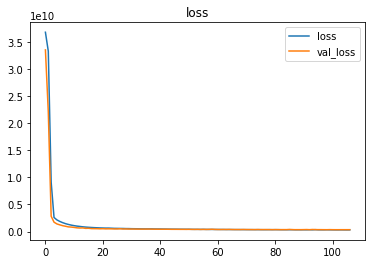

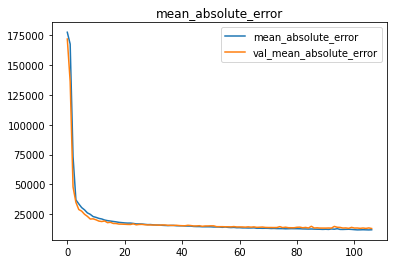

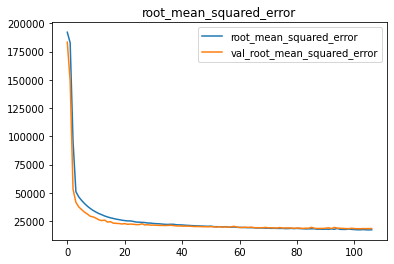

In [ ]:
# plot learning

plot_history(history)

In [ ]:
evaluate_regression(model2, X_test_processed, y_test, label="Test Data");
# Early Stopping

5/5 [==============================] - 0s 3ms/step
------------------------------------------------------------
REGRESSION REPORT FOR: Test Data
------------------------------------------------------------
final RMSE: 18360.0
final MAE: 13150.0
final R2: 0.9174


This model trained really fast and with the best R2 so far! I will try dropout to see if I can do any better.

This model trained really fast but the R2 dropped.  I will try using L1 and L2 regulation with early stopping to see if I can do any better.

In [ ]:
# create model

from keras import regularizers

#del model4


model4 = Sequential()

model4.add(Dense(200, input_dim = input_dim, activation = 'relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.L2(1e-4),
    activity_regularizer=regularizers.L2(1e-5)))
model4.add(Dense(150, activation = 'relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.L2(1e-4),
    activity_regularizer=regularizers.L2(1e-5)))
model4.add(Dense(100, activation = 'relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.L2(1e-4),
    activity_regularizer=regularizers.L2(1e-5)))
model4.add(Dense(50, activation = 'relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.L2(1e-4),
    activity_regularizer=regularizers.L2(1e-5)))
model4.add(Dense(1, activation = 'linear'))
model4.compile(loss = 'mse',
               optimizer = 'adam',
               metrics=[metrics.MeanAbsoluteError(),metrics.RootMeanSquaredError()])

In [ ]:
# fit your model
%%time
history = model4.fit(X_train_processed, y_train,
                    validation_data=(X_test_processed, y_test),
                    epochs=200,
                    verbose=0,
                    callbacks=[early_stopping])

CPU times: user 16.6 s, sys: 551 ms, total: 17.2 s
Wall time: 14.5 s


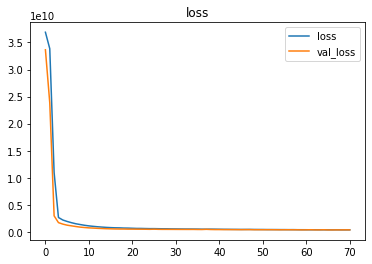

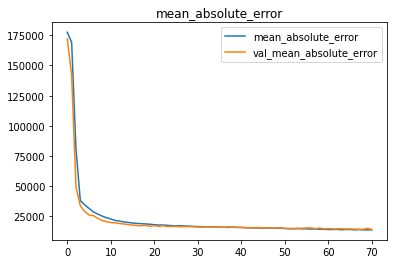

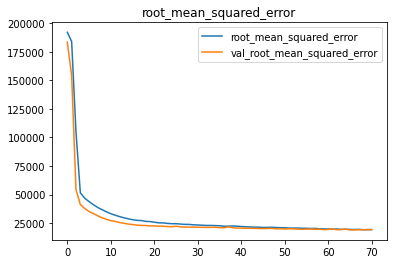

In [ ]:
# plot learning

plot_history(history)

In [ ]:
evaluate_regression(model4, X_test_processed, y_test, label="Test Data");
# Early stopping and L1/L2

5/5 [==============================] - 0s 2ms/step
------------------------------------------------------------
REGRESSION REPORT FOR: Test Data
------------------------------------------------------------
final RMSE: 19360.0
final MAE: 14260.0
final R2: 0.9082


# All the code below is me trying to figure out how to test the Kaggle test data.  Please ignore.

In [ ]:
filename = '/content/kaggle_test (2).csv'
kaggle_df = pd.read_csv(filename)
kaggle_df.head()

FileNotFoundError: ignored

In [ ]:
kaggle_df.isna().sum()

In [ ]:
kaggle_df.shape

In [ ]:
X_train.shape

In [ ]:
kaggle_df_processed = preprocessor.transform(kaggle_df)

In [ ]:
np.isnan(kaggle_df_processed).sum()

In [ ]:
test_pred = model2.predict(kaggle_df_processed).flatten()


In [ ]:
test_pred

In [ ]:
test_pred.shape

In [ ]:
type(kaggle_predictions)

In [ ]:
id_col = pd.read_csv('/content/test.csv')

In [ ]:
submission = pd.DataFrame({'Id': id_col['Id'], 'SalePrice': test_pred})
submission.head()

In [ ]:
submission.to_csv('predictions20221209.csv', index = False)

# Middle of the pack on the leaderboard.  How can I do better?

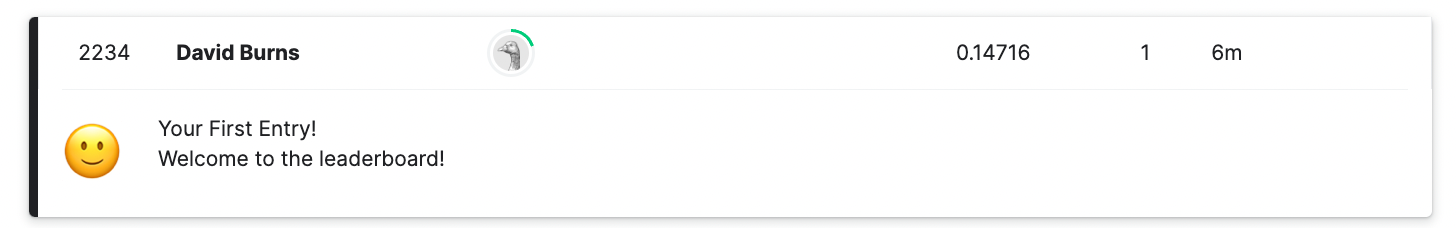